In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

VGG16

Computing mean distance.

Initialization for the layer in NN: 

$W_i \sim U(-\sqrt{k}, \sqrt{k})$
where $k = \frac 1 {N_{in}}$

$N_{in}$ - nubmer of input parameters for the weights. 

$N_{w}$ - numver of weights in the layer.

mean square dist between two layers in Linear layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \frac{ \left (2 \sqrt k \right )^2} {12}  = \frac {2 N_{w}} {3 N_{in}}$

for convolution layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \left (\sqrt \frac 2 {n} \right )$

where n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels

In [3]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

In [4]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [5]:
# distance for VGG16 network:
DIST = 0
i=1
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        print(i, m)
        i+=1
        N_in = m.in_channels*np.prod(m.kernel_size)
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        N_w = np.prod(m.weight.shape)
#         +np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2*N_w*2/n
    if isinstance(m, torch.nn.Linear):
        print(i, m)
        i+=1
        N_in = m.in_features
        N_w = np.prod(m.weight.shape)+np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2/3*float(N_w)/float(N_in)
        

print()        
print('Distance', (np.sqrt(DIST)))

1 Linear(in_features=784, out_features=2000, bias=True)
N_in 784
N_w 1570000
2 Linear(in_features=2000, out_features=10, bias=True)
N_in 2000
N_w 20010

Distance 36.629278092878685


In [6]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [7]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)
model_Arc = architecture.base(num_classes=10, **architecture.kwargs)

model5 = architecture.base(num_classes=10, **architecture.kwargs)
# model5.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-0.pt')['model_state'])

# model1.load_state_dict(torch.load('curves_mnist/LogRegression/curve1/checkpoint-20.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LogRegression/curve2/checkpoint-20.pt')['model_state'])

# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])
# model_Arc.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])

In [8]:
class LinearOneLayerBase(nn.Module):
    def __init__(self, num_classes, in_dim):
        super(LinearOneLayerBase, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 2000),
            nn.ReLU(True),
            nn.Linear(2000, num_classes),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
#                 print('dd')
                n = 28*28
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [9]:
model2 = LinearOneLayerBase(10, 784)
model1 = LinearOneLayerBase(10, 784)

In [10]:
list(model1.parameters())[0].requires_grad = False
list(model1.parameters())[1].requires_grad = False

In [758]:
distance(model1, model2)

89.957855

In [748]:
S_initial1 = samples(model1)
S_initial2 = samples(model2)

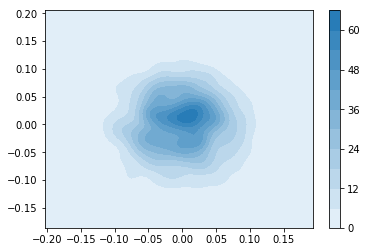

In [750]:
sns.kdeplot(S_initial1[:, 1], S_initial1[:, 2], shade=True,  cbar=True)

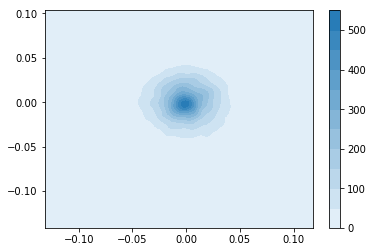

In [698]:
sns.kdeplot(S1[:, -1], S1[:, -2], shade=True,  cbar=True)

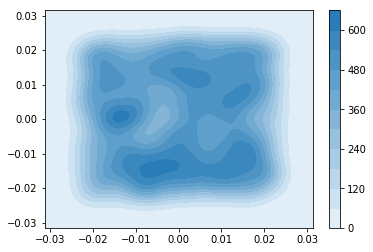

In [694]:
sns.kdeplot(S_initial2[:, -1], S_initial2[:, -2], shade=True,  cbar=True)

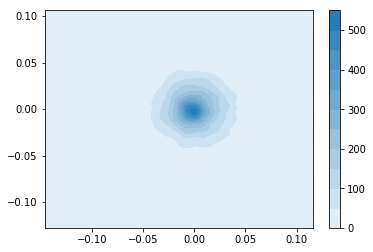

In [699]:
sns.kdeplot(S2[:, -1], S2[:, -2], shade=True,  cbar=True)

In [759]:
model1.cuda()
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, model1.parameters()),
    lr=1,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], model1, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], model1, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     1.1512    85.9417     0.4095    89.7500     4.2297
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.3238    92.2033     0.2578    92.7100     4.1757
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.2378    93.8050     0.1675    95.0900     4.2152
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.1710    95.0583     0.1669    95.1700     4.0876
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [760]:
model2.cuda()
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, model2.parameters()),
    lr=1,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], model2, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], model2, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     0.3951    91.9050     0.1074    96.6700     4.2495
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.0850    97.3917     0.0844    97.4000     4.1439
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.0558    98.3750     0.0724    97.8400     4.1502
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.0380    98.9183     0.0629    98.1300     4.1418
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [761]:
distance(model1, model2)

103.84035

In [762]:
model1.cpu();
S1 = samples(model1)
model2.cpu();
S2 = samples(model2)

In [763]:
def get_importante_weights(S, koef=0.01):
    mask = np.zeros(795)
    mask[S[:, :].var(axis=0)>koef]=1
    mask = mask[:784].reshape((28, 28))
    return mask

In [774]:
mask1 = get_importante_weights(S1, koef=0.001)
mask2 = get_importante_weights(S2, koef=0.001)

In [780]:
# mask1

In [775]:
def find_masked_distance(mask1, mask2, S_initial1, S_initial2):

    mask = mask1*mask2
    mask = mask.reshape(-1).astype(int)
    S_initial1, S_initial2 = S_initial1[:, :784], S_initial2[:, :784]
#     print(mask)
#     print(S_initial1.shape)
#     mask = np.ones(784)
    S_initial1, S_initial2 = S_initial1[: :]*mask, S_initial2[:, :]*mask
#     print(S_initial1)
    dx = S_initial1 - S_initial2
    distance = np.sqrt((dx*dx).sum())
    return distance, S_initial1

In [776]:
a, b = find_masked_distance(mask1, mask2, S1, S2)
a

93.9687482583595

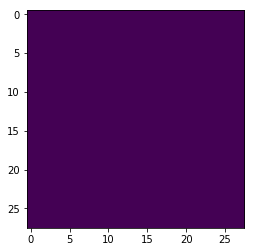

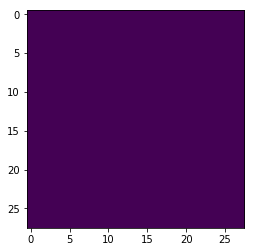

In [777]:
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)

In [781]:
# np.arange(795)[S1[:, :].var(axis=0)>0.001]

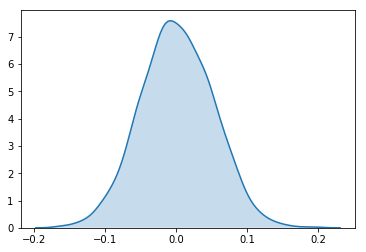

In [782]:
sns.kdeplot(S1[:, 500], shade=True,  cbar=True)

In [783]:
S1[:, 500].var()

0.0026000175

In [784]:
S1[:, 790].var()

0.07577849

In [711]:
S1.shape

(2000, 795)

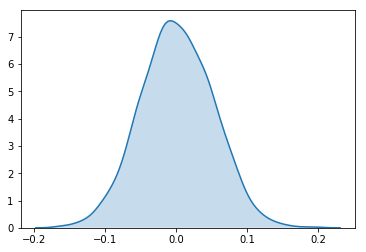

In [791]:
sns.kdeplot(S1[:, 500], shade=True,  cbar=True)

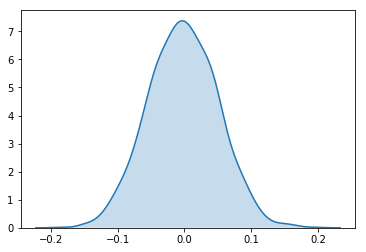

In [792]:
sns.kdeplot(S2[:, 500], shade=True,  cbar=True)

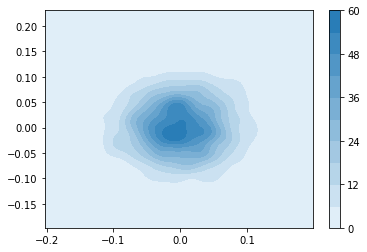

In [793]:
sns.kdeplot(S1[:, 37], S1[:, 500], shade=True,  cbar=True)

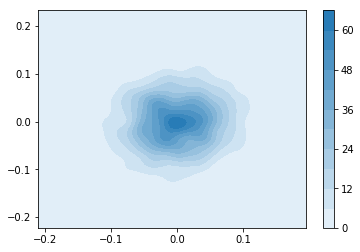

In [794]:
sns.kdeplot(S2[:, 37], S2[:, 500], shade=True,  cbar=True)

In [795]:
# train_res = utils.test(loaders['train'], model1, criterion, regularizer)
# test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
# train_res, test_res

In [796]:
for parameter, p1, p2 in zip(model5.parameters(), model1.parameters(), model2.parameters()):
    parameter.data.copy_((p1+p2)/2)

In [797]:
ind = 1
T = True

while ind<22:

    ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    for parameter, p in zip(model4.parameters(), m.parameters()):
        if ind == 1:
            parameter.data.copy_((p))
        else:
            parameter.data.copy_((parameter+p))
            
    ind+=1

print('ind', ind)
for parameter in model4.parameters():
    parameter.data.copy_(parameter/ind)


ind 22


In [798]:
for i, (parameter, p1, p2, mu) in enumerate(zip(model_Arc.parameters(), model1.parameters(), model2.parameters(), model4.parameters())):    
    if i!=3:
        parameter.data.copy_(mu + (1/np.sqrt(2))*(p1-mu)+(1/np.sqrt(2))*(p2-mu))
    

In [799]:
checkpoints = torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')

print("Saving checkpoint for node changing")

utils.save_checkpoint(
            'curves_mnist/LinearOneLayer/curve3',
            100,
            name='E',
            model_state=model4.state_dict(),
            optimizer_state=checkpoints['optimizer_state']
            )

Saving checkpoint for node changing


In [800]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, model3.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [802]:
list(model_Arc.parameters())[-1]

Parameter containing:
tensor([ 0.0019, -0.0058,  0.0146,  0.0130, -0.0033, -0.0084,  0.0086,  0.0032,
         0.0040,  0.0099], requires_grad=True)

In [803]:
list(model1.parameters())[-1]

Parameter containing:
tensor([-0.0120,  0.1344, -0.2833, -0.2432, -0.0804,  0.1758,  0.0160, -0.2058,
         0.2666,  0.2318], requires_grad=True)

In [804]:
list(model2.parameters())[-1]

Parameter containing:
tensor([-0.2141, -0.4169, -0.2648, -0.3136,  0.0217, -0.1371,  0.3147, -0.6727,
         1.4842,  0.1983], requires_grad=True)

In [805]:
train_res = utils.test(loaders['train'], model_Arc, criterion, regularizer)
test_res = utils.test(loaders['test'], model_Arc, criterion, regularizer) 
train_res, test_res

({'nll': 0.10031545708576838, 'loss': 0.10031545708576838, 'accuracy': 96.815},
 {'nll': 0.1456833489894867, 'loss': 0.1456833489894867, 'accuracy': 95.49})

In [806]:
train_res = utils.test(loaders['train'], model5, criterion, regularizer)
test_res = utils.test(loaders['test'], model5, criterion, regularizer) 
train_res, test_res

({'nll': 0.22981266481876372,
  'loss': 0.22981266481876372,
  'accuracy': 96.25166666666667},
 {'nll': 0.2497264081954956, 'loss': 0.2497264081954956, 'accuracy': 95.0})

In [807]:
train_res = utils.test(loaders['train'], model1, criterion, regularizer)
test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
train_res, test_res

({'nll': 0.06437447655002276, 'loss': 0.06437447655002276, 'accuracy': 98.12},
 {'nll': 0.1066709920167923, 'loss': 0.1066709920167923, 'accuracy': 96.85})

In [808]:
train_res = utils.test(loaders['train'], model4, criterion, regularizer)
test_res = utils.test(loaders['test'], model4, criterion, regularizer) 
train_res, test_res

({'nll': 2.1608021107991537,
  'loss': 2.1608021107991537,
  'accuracy': 22.321666666666665},
 {'nll': 2.1599566329956055, 'loss': 2.1599566329956055, 'accuracy': 22.4})

In [809]:
train_res = utils.test(loaders['train'], model2, criterion, regularizer)
test_res = utils.test(loaders['test'], model2, criterion, regularizer) 
train_res, test_res

({'nll': 0.0024662952263529102,
  'loss': 0.0024662952263529102,
  'accuracy': 99.99333333333334},
 {'nll': 0.0592628039598465, 'loss': 0.0592628039598465, 'accuracy': 98.32})

In [810]:
train_res = utils.test(loaders['train'], model3, criterion, regularizer)
test_res = utils.test(loaders['test'], model3, criterion, regularizer) 
train_res, test_res

({'nll': 2.3043077946980794,
  'loss': 2.3043077946980794,
  'accuracy': 7.826666666666667},
 {'nll': 2.30461701965332, 'loss': 2.30461701965332, 'accuracy': 7.87})

In [23]:
list(model1.parameters())[0].shape, list(model1.parameters())[1].shape, list(model1.parameters())[2].transpose(0,1).shape

(torch.Size([2000, 784]), torch.Size([2000]), torch.Size([2000, 10]))

In [811]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.numpy()
#     print(p1.shape, p2.shape, p3.shape)
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [814]:
S1 = 2000*samples(model1)
S2 = 2000*samples(model2)

In [815]:
CM1 = np.cov(S1, rowvar=False)
CM2 = np.cov(S2, rowvar=False)

In [816]:
from scipy.stats import kde

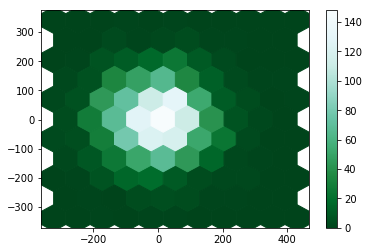

In [817]:
plt.hexbin(S1[:, 0], S1[:, 70], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

In [34]:
X_embedded1 = TSNE(n_components=2).fit_transform(S1)
X_embedded2 = TSNE(n_components=2).fit_transform(S2)

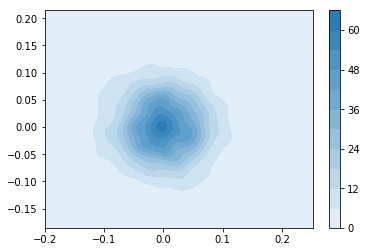

In [845]:
sns.kdeplot(S_initial1[:, 0], S_initial1[:, 790], shade=True,  cbar=True)

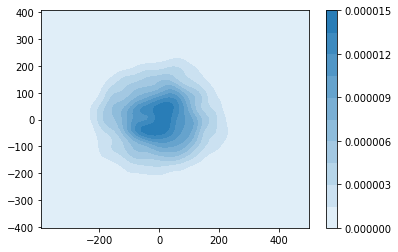

In [844]:
sns.kdeplot(S1[:, 0], S1[:, 70], shade=True,  cbar=True)

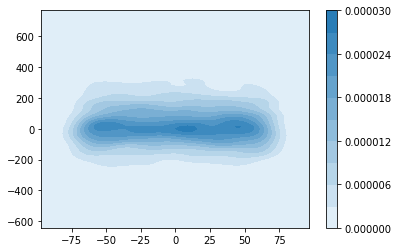

In [305]:
sns.kdeplot(S2[:, 0], S2[:, 790], shade=True,  cbar=True)

In [842]:
sns.kdeplot(X_embedded1[:, 0], X_embedded1[:, 1], shade=True, cbar=True)

NameError: name 'X_embedded1' is not defined

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


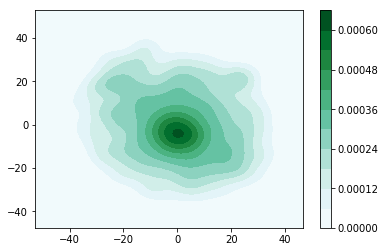

In [44]:
sns.kdeplot(X_embedded2[:, 0], X_embedded2[:, 1], shade=True, cbar=True)

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2, svd_solver='full')
PCA1 = pca.fit_transform(S1)  
PCA2 = pca.fit_transform(S2)  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


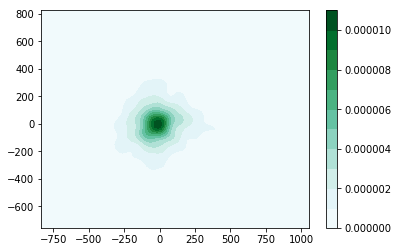

In [47]:
sns.kdeplot(PCA1[:, 0], PCA1[:, 1], shade=True, cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


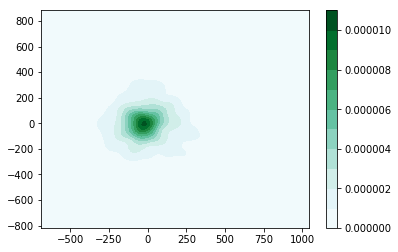

In [48]:
sns.kdeplot(PCA2[:, 0], PCA2[:, 1], shade=True, cbar=True)

## Let model distribution be gaussian, sample from it and see what results we get

In [820]:
ind = 1
T = True
S = []
B = []
# while ind<10:

#     ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
#     checkpoint = torch.load(ckpt)
#     m.load_state_dict(checkpoint['model_state'])
    
#     S.append(2000*samples(m))
#     B.append(list(m.parameters())[-1].data.numpy())
#     ind+=1

In [821]:
B.append(list(model1.parameters())[-1].data.numpy())

In [822]:
B = np.array(B)

In [837]:
B[0]

array([-0.01198832,  0.13439709, -0.28331888, -0.24317376, -0.08038262,
        0.17582034,  0.01595621, -0.20576544,  0.266556  ,  0.23180848],
      dtype=float32)

In [824]:
# S = np.vstack(S)

In [857]:
S = samples(model2)

In [858]:
S.shape

(2000, 795)

In [859]:
CM = np.cov(S, rowvar=False)

In [860]:
SIZE = 2000
model_samples = np.random.multivariate_normal(S.mean(0), CM, size=SIZE)

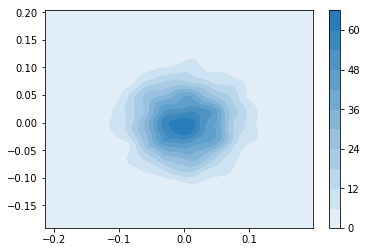

In [861]:
sns.kdeplot(model_samples[:, 0], model_samples[:, 1], shade=True, cbar=True)

In [862]:
model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
# model_sampled.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])

In [863]:
offset = 0
for parameter in list(model_sampled.parameters())[:-1]:
    size = int(np.prod(parameter.size())/SIZE)
    value = model_samples[:, offset:offset+size]
    if size==10 or size==1:
         value = value.T
    print(value.shape)
    value = value.reshape(parameter.size())
    print(value.shape)
    parameter.data.copy_(torch.from_numpy(value))
    offset += size

list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))

(2000, 784)
(2000, 784)
(1, 2000)
(2000,)
(10, 2000)
(10, 2000)


tensor([-0.0120,  0.1344, -0.2833, -0.2432, -0.0804,  0.1758,  0.0160, -0.2058,
         0.2666,  0.2318])

In [864]:
train_res = utils.test(loaders['train'], model_sampled, criterion, regularizer)
test_res = utils.test(loaders['test'], model_sampled, criterion, regularizer) 
train_res, test_res

({'nll': 57.40088598022461,
  'loss': 57.40088598022461,
  'accuracy': 17.263333333333332},
 {'nll': 58.56353099365234, 'loss': 58.56353099365234, 'accuracy': 17.25})

## What if train the model

In [865]:
int((795*795-795)/2+2*795)

317205

In [866]:
795*2000

1590000

In [867]:
28*28

784

In [868]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True
)

You are going to run models on the test set. Are you sure?


In [869]:
for X, y in loaders['test']:
    break

## Generator 

In [296]:
class Generator(nn.Module):
    def __init__(self, n_dim=795, N_layers=2):
        super(Generator, self).__init__()
        
        self.in_dim = 795
        self.proposal = nn.Sequential(nn.Linear(795, 795*2),
                                nn.Tanh(),
                                nn.Linear(795*2, 795),
                                nn.Tanh(),
                                nn.Linear(795, 795*2),
                                nn.Tanh(),
                                nn.Linear(795*2, 795),
                                nn.Tanh(),
#                                 nn.Linear(795, 795*2),
#                                 nn.Tanh(),
#                                 nn.Linear(795*2, 795),
#                                 nn.Tanh(),
                               )
        
        
        self.W1 = nn.Linear(795, 784)
        self.b1 = nn.Linear(795, 1)
        self.W2 = nn.Linear(795, 10)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)
        
        self.relu = nn.ReLU()
        
        self.mult = torch.tensor([1/28]*785 + [1/np.sqrt(2000)]*10).cuda()

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e) 
            e = 2*(e-0.5)
#             e = self.mult*e
        else:
            e = torch.randn((K, self.in_dim)).cuda()  
        return e
    
    def sample_weights(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.rand(shape, out=e)  
        else:
            e = torch.rand((K, self.in_dim))  
            
        z = self.proposal(e)
        W1 = self.W1(z)
        b1 = self.b1(z)
        W2 = self.W2(z)
        
        e = torch.cat([W1, b1, W2], -1)
        return e

    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        e = self.sample(K)
        z = self.proposal(e)
        W1 = self.W1(z)
        b1 = self.b1(z)[:, 0]
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        
#         for i in range(int(self.n_dim-784-10/2), 2):
#             Wi = W[:, 785+i]
#             bi = W[:, 786+i]
#             x = self.relu(Wi*x+bi)
        
        W2 = self.W2(z).transpose(0,1)
 

        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [297]:
G = Generator()

In [298]:
G.cuda();

In [299]:
criterion = F.cross_entropy
regularizer = None 

In [302]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.000001,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], G, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     0.1378    95.8117     0.1807    94.9700     5.8845
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.1359    95.9000     0.1793    94.9700     5.8723
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.1368    95.8833     0.1818    94.8900     5.8820
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.1371    95.8900     0.1796    94.9700     5.8741
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

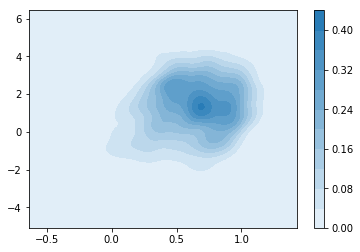

In [304]:
samples = G.sample_weights(2000).cpu().data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [99]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.0001,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], G, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     0.1212    96.3533     0.1743    95.7300     5.7522
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.1116    96.5467     0.1623    95.6400     5.7388
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.1040    96.7817     0.1624    95.8700     5.7500
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.1013    96.8750     0.1676    96.0500     5.7654
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [148]:
def di(samples1, samples2):
    dx = (samples1 - samples2)
    dictance = np.sqrt((dx*dx).sum())
    print(dictance)

In [150]:
S = [1/2000*G.sample_weights(2000).cpu().data.numpy() for _ in range(4)]


In [152]:
for i in range(4):
    for j in range(i+1, 4):
        print(i, j) 
        di(S[i], S[j])

0 1
6.028146
0 2
5.991811
0 3
6.0165396
1 2
6.0026054
1 3
6.0141177
2 3
5.9938226


In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.01,
    weight_decay=0.
)
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

#     utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.2896    11.5267     2.2839    11.1000   244.8504


In [116]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

KeyboardInterrupt: 

In [112]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.001,
    weight_decay=0.5
)
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

#     utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     1.7253    39.2683     2.1102    20.6800   214.1120
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1600    20.8400     2.2362    20.8700   227.0089
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.2721    19.5883     2.2902    19.2900   504.5819


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Flow Generator 

In [45]:
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x
    
class TNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(TNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x

In [46]:
nets = SNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = TNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ex_nets = nets(dim_in, dim_middle)
# ex_mett = nett(dim_in, dim_middle)

In [47]:
import numpy as np
N_layers = 3
masks = torch.Tensor((np.vstack([[1, 0]*N_layers, [0, 1]*N_layers]).T)) # torch.Tensor of size #number_of_coupling_layers x #dim(X)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [48]:
from torch import distributions

In [49]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
#         print('len', len(mask))
        self.t = torch.nn.ModuleList([nett(dim_in=795, dim_middle=1000) for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets(dim_in=795, dim_middle=1000) for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t) in enumerate(zip(reversed(self.s), reversed(self.t))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
#             print('z', z.shape)
            z = m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m in zip(self.s, self.t, self.mask):
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
            log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        
#         m = MultivariateNormal(torch.zeros(batchSize), torch.eye(batchSize))
        z = self.prior.sample((K, ))
        x = self.g(z)
        
        return x

In [50]:
class Gaussian_Flow(nn.Module):
    def __init__(self, n_dim=795, N_layers=2):
        super(Gaussian_Flow, self).__init__()
        
        onezero = [0, 1]*n_dim
        masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
        masks = masks.view(2*N_layers, -1)
#         print('masks', masks, masks.shape)
        prior = distributions.MultivariateNormal(torch.zeros(n_dim), torch.eye(n_dim))
        
        self.nvp = RealNVP(nets, nett, masks, prior)
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)


    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.nvp.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        print('x', x.shape)
        print('W1', W1.shape)
        print('b1', b1.shape)
        x = F.linear(x, W1, b1[:, 0])
        print('x', x.shape)
#         x = W1 @ x #+ b1
        print(x.shape)
        x = self.relu(x)
#         print('W2', W2.shape)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x
        print(x.shape)
        return x

In [51]:
GF = Gaussian_Flow(n_dim=795, N_layers=1)

In [52]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GF.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [53]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GF, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GF, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

x torch.Size([128, 784])
W1 torch.Size([2000, 784])
b1 torch.Size([2000, 1])
x torch.Size([128, 2000])
torch.Size([128, 2000])
torch.Size([128, 10])


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Trainig mean and covariance matrix One hidden layer

In [18]:
class Gaussian_model(nn.Module):
    def __init__(self, n_dim=795):
        super(Gaussian_model, self).__init__()
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        self.in_dim = n_dim
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e)   
        else:          
            e = torch.randn((K, self.in_dim))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=20000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        x = F.linear(x, W1, b1[:, 0])
        x = self.relu(x)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [19]:
GM = Gaussian_model()
GM.cuda();

In [22]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, GM.parameters()),
    lr=0.01,
#     momentum=0.9,
)

In [23]:
columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()


    train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.3081    91.3167     0.2685    91.9900     7.5937
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.2685    92.0917     0.2484    93.2200     7.5749
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.2631    92.3567     0.2584    92.7600     7.6197
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.2607    92.3900     0.2583    92.8700     7.6181
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.2516    92.5583     0.2549    92.8400     7.6093
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [884]:
# GM(X)[0]

In [887]:
# test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)
# test_res

In [260]:
samples = GM.sample(2000).data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


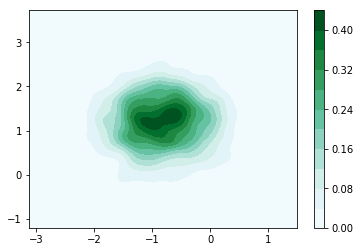

In [264]:
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [277]:
X_embeddeds = TSNE(n_components=2).fit_transform(samples)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


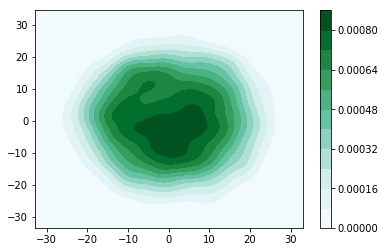

In [279]:
sns.kdeplot(X_embeddeds[:, 0], X_embeddeds[:, 1], shade=True,  cbar=True)

## Trainig mean and covariance matrix Several hidden layer

In [249]:
class GMMultyLayer(nn.Module):
    def __init__(self, n_dim=809):
        super(GMMultyLayer, self).__init__()
        self.n_dim = n_dim
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_bf = torch.FloatTensor(np.random.normal(size=(10, )))
        self.bf = nn.Parameter(data = data_bf, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=4000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784]
        
        W2 = W[:, 785]
        b2 = W[:, 786]
        Wf =  W[:, -10:].transpose(0,1)
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        for i in range(int(self.n_dim-784-10/2), 2):
            Wi = W[:, 785+i]
            bi = W[:, 786+i]
            x = self.relu(Wi*x+bi)
            
        x = F.linear(x, Wf, self.bf) 
        x = 1/K*x
#         print(x.shape)
        return x

In [250]:
GML = GMMultyLayer()

In [251]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GML.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [252]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.7916    14.3017     2.2235    14.8000    93.5746
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1833    15.8317     2.1439    18.0300    91.0075
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.0937    24.0500     2.0191    30.7600    90.9785
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.9095    36.9383     1.7213    47.6100    90.6315
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  